In [14]:
import matplotlib.pyplot as plt
import numpy as np
from   numpy.linalg import inv
import numpy.random as npr
from   pypolyagamma import PyPolyaGamma
from scipy.stats import multivariate_normal
import pandas as pd

In [15]:
# シグモイド関数
def sigmoid(x):
    """Numerically stable sigmoid function.
    """
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)),
                    np.exp(x) / (1 + np.exp(x)))

def multi_pgdraw(pg, B, C):
    """Utility function for calling `pgdraw` on every pair in vectors B, C.
    """
    return np.array([pg.pgdraw(b, c) for b, c in zip(B, C)])

def lamda(x, beta):
    X = np.vstack([np.ones(x.shape), x, x**2]).T
    return np.exp(X@beta)

def sample_inhomogeneous_poisson_process(beta, T):
    # 最大強度を見つけるために、強度関数の最大値を計算
    x = np.linspace(0, T, 1000)
    max_lambda = np.max(lamda(x, beta))
    
    # サンプリングするイベントを格納するリスト
    events = []
    t = 0

    while t < T:
        # 次の候補イベントの間隔を指数分布からサンプリング
        u = np.random.uniform()
        t += -np.log(u) / max_lambda
        
        # 時刻 t での強度関数の値
        if t < T:
            lambda_t = lamda(np.array([t]), beta)
            
            # 強度関数の値に基づいてイベントを受け入れるか拒否するか決定
            if np.random.uniform() < lambda_t / max_lambda:
                events.append(t)
    
    return np.array(events)

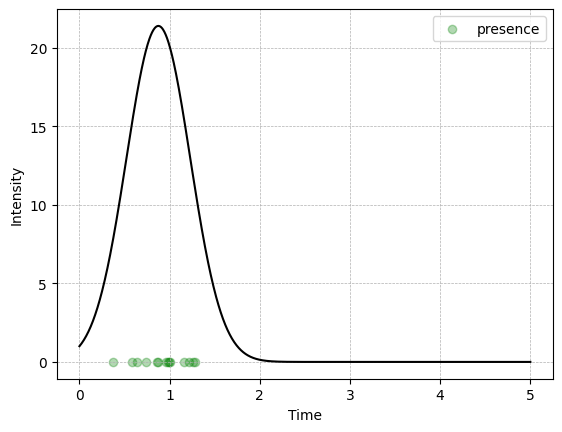

In [16]:
beta_true = np.array([0, 7, -4])
events = sample_inhomogeneous_poisson_process(beta_true, 5)

t1= np.array(events)
x_lin = np.linspace(0, 5, 1000)
intensity = lamda(x_lin, beta_true)
plt.scatter(t1, np.zeros(len(t1)), c='green', alpha=0.3, label='presence')
plt.plot(x_lin, intensity, c='black')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [17]:
import scipy
    
def generate_IPP(beta_true, n0, verbose=False):
    # 1次元の非斉次ポアソン過程モデル
    T = 5

    def lamda(x, beta):
        X = np.vstack([np.ones(x.shape), x, x**2]).T
        return np.exp(X@beta)

    x_lin = np.linspace(0, T, 1000)
    intensity = lamda(x_lin, beta_true)
    
    if verbose:
        plt.plot(x_lin, intensity, c='black')
        plt.xlabel('Time')
        plt.ylabel('Intensity')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.show()

    # サンプリングするイベントを格納するリスト
    events = []
    t = 0
    
    max_lambda = np.max(intensity)

    while t < T:
        # 次の候補イベントの間隔を指数分布からサンプリング
        u = np.random.uniform()
        t += -np.log(u) / max_lambda
        
        # 時刻 t での強度関数の値
        if t < T:
            lambda_t = lamda(np.array([t]), beta_true)
            
            # 強度関数の値に基づいてイベントを受け入れるか拒否するか決定
            if np.random.uniform() < lambda_t / max_lambda:
                events.append(t)

    t1 = np.array(events)    

    n1 = len(t1)
    
    # background data: 一様分布からのサンプリング
    t0 = np.random.uniform(0, T, n0)

    if verbose:
        plt.scatter(t0, np.zeros(n0), c='grey', alpha=0.4, label='pseudo-absence')
        plt.scatter(t1, np.zeros(len(t1)), c='green', alpha=0.3, label='presence')
        plt.plot(x_lin, intensity, c='black')
        plt.xlabel('Time')
        plt.ylabel('Intensity')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()

    n = n1 + n0
    t = np.concatenate([t1, t0])
    X = np.vstack([np.ones(n), t, t**2]).T
    y = np.concatenate([np.ones(n1), np.zeros(n0)]).astype(int)
    
    return X, y, t1, t0


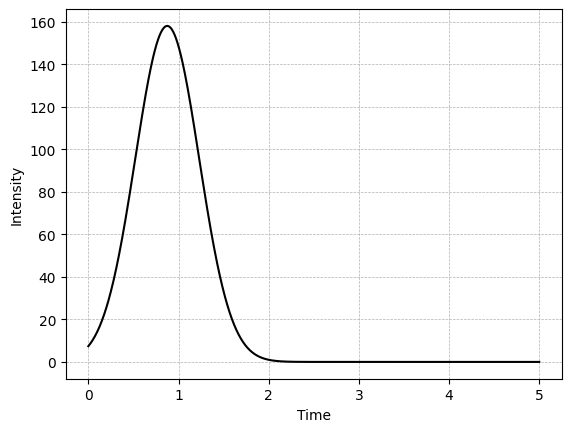

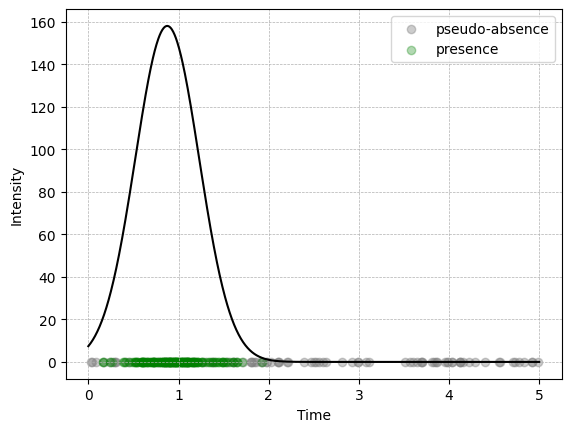

Number of presence: 151
Number of absence: 100


In [18]:



beta_true = np.array([2, 7, -4])
n0 = 100
Z = 1000

X, y, t1, t0 = generate_IPP(beta_true, n0, verbose=True)


print(f"Number of presence: {len(t1)}")
print(f"Number of absence: {len(t0)}")


In [19]:
import scipy.optimize as opt

# ロジスティック回帰モデルの最尤推定

def negative_log_likelihood(beta, X, y, z):
    h = sigmoid(X@beta)
    return -np.sum(y * np.log(h) + (1 - y) * z * np.log(1 - h))

z = np.concatenate([np.ones(len(t1)), np.ones(len(t0))*Z])
beta_hat = opt.fmin_bfgs(negative_log_likelihood, np.random.normal(size=3), args=(X, y, z))

beta_hat

         Current function value: nan
         Iterations: 2
         Function evaluations: 456
         Gradient evaluations: 114


/tmp/ipykernel_3512048/4000094886.py:6: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-x)),
/tmp/ipykernel_3512048/4000094886.py:7: RuntimeWarning: overflow encountered in exp
  np.exp(x) / (1 + np.exp(x)))
/tmp/ipykernel_3512048/4000094886.py:7: RuntimeWarning: invalid value encountered in divide
  np.exp(x) / (1 + np.exp(x)))
/tmp/ipykernel_3512048/865801438.py:7: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(h) + (1 - y) * z * np.log(1 - h))
/tmp/ipykernel_3512048/865801438.py:7: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y * np.log(h) + (1 - y) * z * np.log(1 - h))
/tmp/ipykernel_3512048/4000094886.py:6: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-x)),
/tmp/ipykernel_3512048/4000094886.py:7: RuntimeWarning: overflow encountered in exp
  np.exp(x) / (1 + np.exp(x)))
/tmp/ipykernel_3512048/4000094886.py:7: RuntimeWarning: invalid value encountered in divide
  np.exp(x) / (1 + np.exp(x)))
/t

array([-1029472.49325342,   -79856.76226717,   141716.26750841])

## 繰り返し推定して漸近的性質を確認

In [20]:
beta_true = np.array([2, 7, -4])

n0_candidates = np.array([10, 100, 1000, 10000])
Z_candidates = np.array([1, 10, 100, 1000, 10000, 100000])

n_estimate = 1000
beta_estimated = np.empty((n_estimate, len(n0_candidates), len(Z_candidates), 3))
n1_estimated = np.empty((n_estimate, len(n0_candidates), len(Z_candidates)))

"""
# warningを非表示
import warnings
warnings.filterwarnings('ignore')
for i in tqdm(range(n_estimate)):
    for j, n0 in enumerate(n0_candidates):
        X, y, t1, t0 = generate_IPP(beta_true, n0)
        for k, Z in enumerate(Z_candidates):
            z = np.concatenate([np.ones(len(t1)), np.ones(len(t0))*Z])    
            n1_estimated[i, j, k] = len(t1)
            beta_estimated[i, j, k] = opt.fmin_bfgs(negative_log_likelihood, np.random.normal(size=3), args=(X, y, z), disp=False)
"""

"\n# warningを非表示\nimport warnings\nwarnings.filterwarnings('ignore')\nfor i in tqdm(range(n_estimate)):\n    for j, n0 in enumerate(n0_candidates):\n        X, y, t1, t0 = generate_IPP(beta_true, n0)\n        for k, Z in enumerate(Z_candidates):\n            z = np.concatenate([np.ones(len(t1)), np.ones(len(t0))*Z])    \n            n1_estimated[i, j, k] = len(t1)\n            beta_estimated[i, j, k] = opt.fmin_bfgs(negative_log_likelihood, np.random.normal(size=3), args=(X, y, z), disp=False)\n"

In [21]:
beta_estimated = pd.read_csv('beta_estimated.csv', header=None).values.reshape(1000, 4, 6, 3)
beta_estimated.shape

(1000, 4, 6, 3)

In [22]:
beta_pred = beta_estimated[:, 1, 3, :]
beta_pred = beta_pred[np.all(np.abs(beta_pred) < 100, axis=1)]
beta_pred.shape

(895, 3)

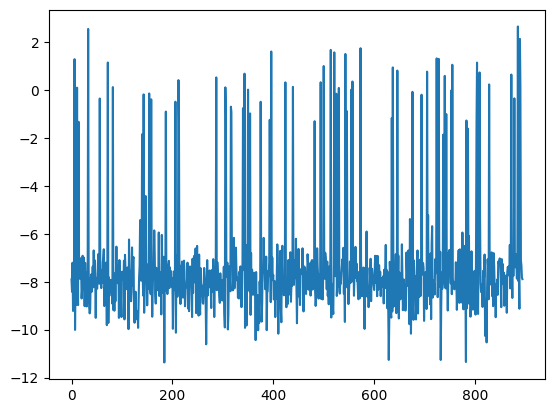

In [24]:
plt.plot(beta_pred[:, 0])

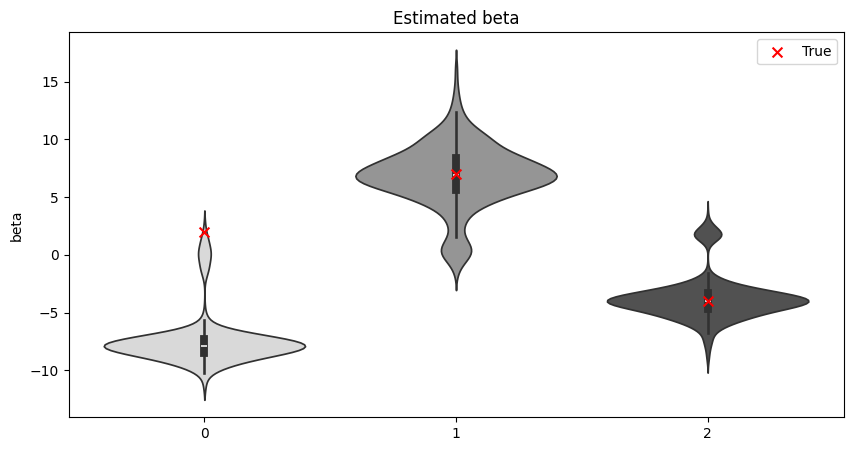

In [25]:
plt.figure(figsize=(10, 5))
# violinplot
import seaborn as sns
sns.violinplot(data=beta_pred, palette='Greys')
plt.scatter([0, 1, 2], beta_true, c='red', label='True', marker='x', s=50, zorder=10)

plt.title("Estimated beta")#グラフのタイトル
plt.ylabel('beta')#ｙ軸ラベル
plt.xlabel("")#x軸ラベルの消去
plt.legend()

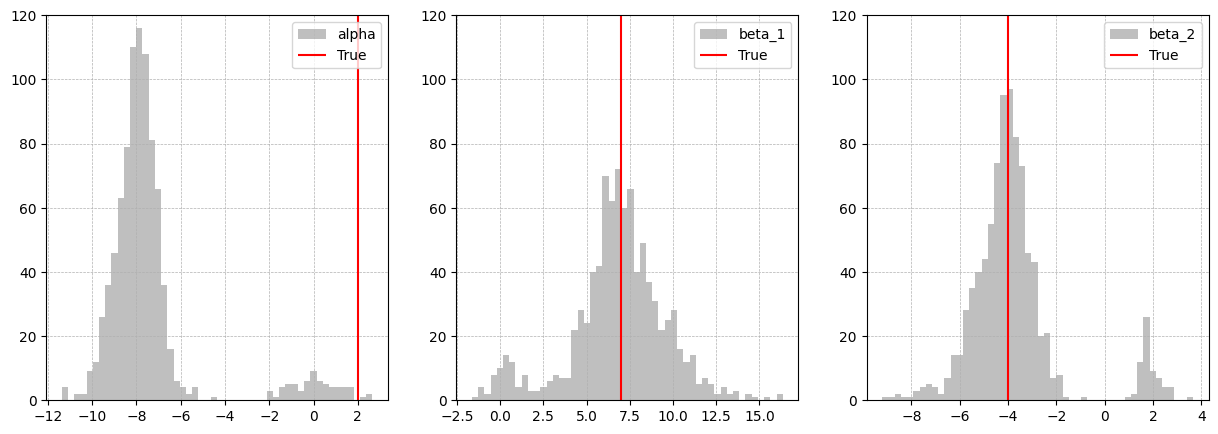

In [26]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(beta_pred[:, 0], bins=50, color='grey', alpha=0.5, label='alpha')
plt.vlines(beta_true[0], 0, 150, color='red', label='True')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(0, 120)
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(beta_pred[:, 1], bins=50, color='grey', alpha=0.5, label='beta_1')
plt.vlines(beta_true[1], 0, 150, color='red', label='True')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(0, 120)
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(beta_pred[:, 2], bins=50, color='grey', alpha=0.5, label='beta_2')
plt.vlines(beta_true[2], 0, 150, color='red', label='True')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(0, 120)
plt.legend()

In [27]:
beta_mean = beta_pred.mean(axis=0)
beta_mean

array([-7.40275797,  6.83990071, -3.77293366])

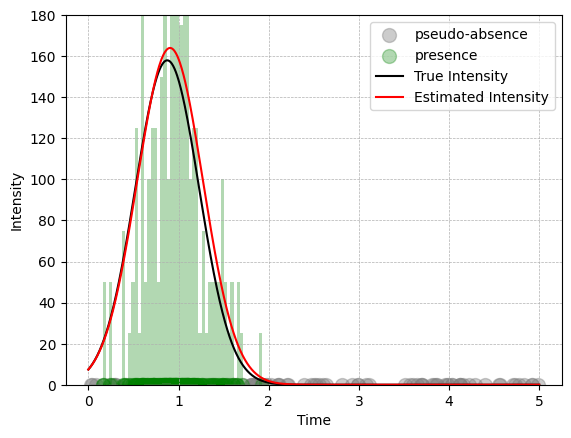

In [28]:
plt.scatter(t0, np.zeros(n0), c='grey', alpha=0.4, label='pseudo-absence', s=100)
plt.scatter(t1, np.zeros(len(t1)), c='green', alpha=0.3, label='presence', s=100)


plt.hist(t1, bins=50, color='green', alpha=0.3, weights=25*np.ones(len(t1)))
plt.hist(t0, bins=50, color='grey', alpha=0.3, weights=np.ones(len(t0))/10)
t_lin = np.linspace(0, 5, 1000)
X_lin = np.vstack([np.ones(1000), t_lin, t_lin**2]).T
plt.plot(t_lin, lamda(t_lin, beta_true), c='black', label='True Intensity')

#for beta in beta_pred:
#    plt.plot(t_lin, lamda(t_lin, beta), c='black', alpha=0.1)

beta_mean[0] = 2
plt.plot(t_lin, lamda(t_lin, beta_mean), c='red', label='Estimated Intensity')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.ylim(0, 180)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

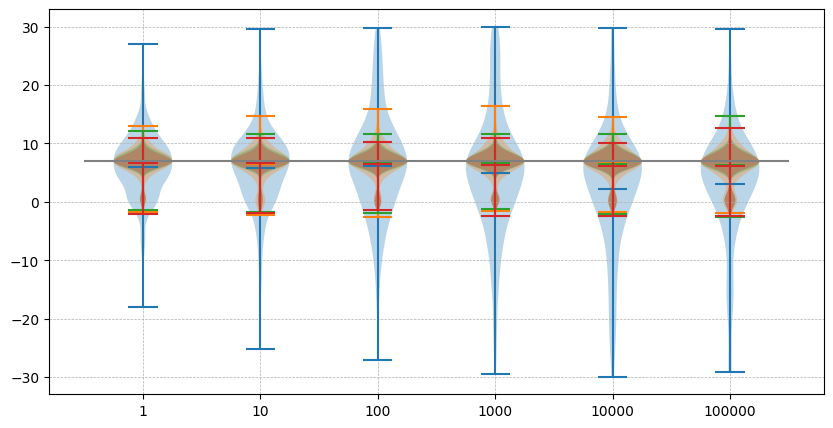

In [29]:

betas_list_list = []
for i in range(4):
    betas_list = []
    for j in range(6):
        betas = beta_estimated[:, i, j, 1]
        betas = betas[np.abs(betas) < 30]
        betas_list.append(betas)
    betas_list_list.append(betas_list)

plt.figure(figsize=(10, 5))
for i in range(4):
    plt.violinplot(betas_list_list[i], showmeans=True, showmedians=False)
    
plt.hlines(beta_true[1], 0.5, 6.5, color='grey', label='True')
plt.xticks([1, 2, 3, 4, 5, 6], Z_candidates)
plt.grid(True, linestyle='--', linewidth=0.5)

plt.show()

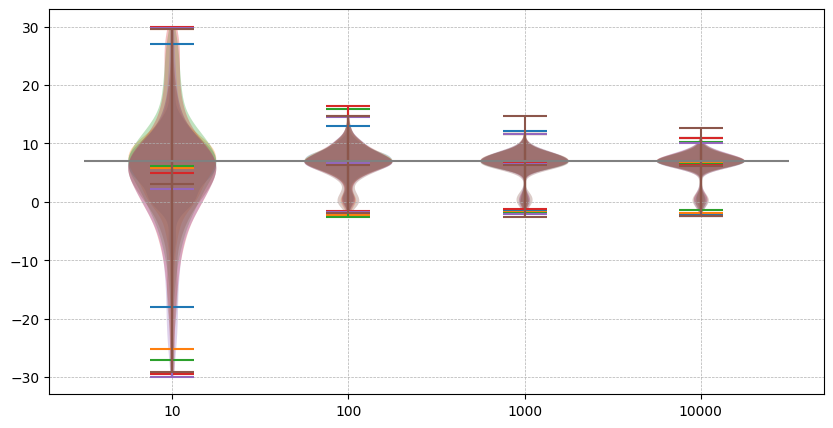

In [30]:
betas_list_list = []
for i in range(6):
    betas_list = []
    for j in range(4):
        betas = beta_estimated[:, j, i, 1]
        betas = betas[np.abs(betas) < 30]
        betas_list.append(betas)
    betas_list_list.append(betas_list)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.violinplot(betas_list_list[i], showmeans=True, showmedians=False)
    
plt.hlines(beta_true[1], 0.5, 4.5, color='grey', label='True')
plt.xticks([1, 2, 3, 4], n0_candidates)
plt.grid(True, linestyle='--', linewidth=0.5)

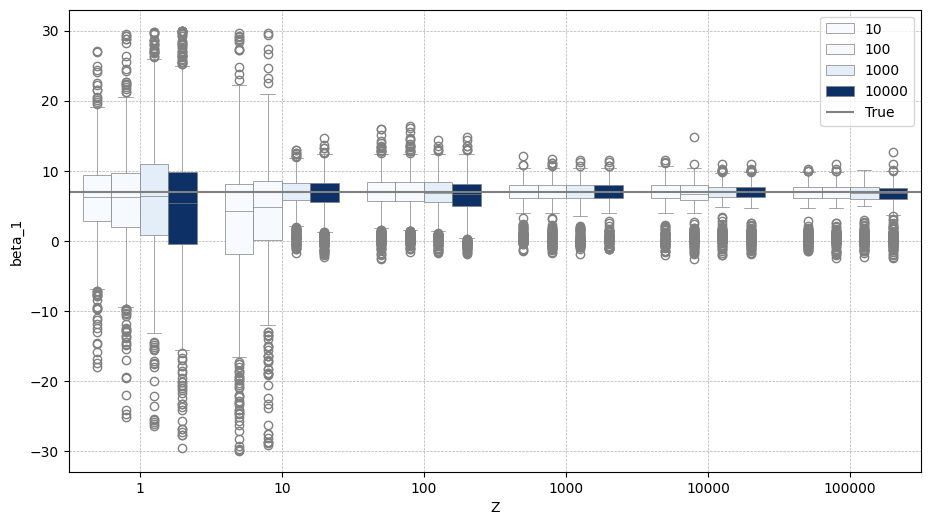

In [31]:
beta_df = pd.DataFrame(beta_estimated.reshape(-1, 3), columns=['alpha', 'beta_1', 'beta_2'])
beta_df['n0'] = np.tile(n0_candidates, 6000)
beta_df['Z'] = np.tile(np.repeat(Z_candidates, 4), 1000)

beta_df = beta_df[beta_df['alpha'].abs() < 30]
beta_df = beta_df[beta_df['beta_1'].abs() < 30]
beta_df = beta_df[beta_df['beta_2'].abs() < 30]

plt.figure(figsize=(11, 6))
sns.boxplot(x='Z', y='beta_1', data=beta_df, hue='n0', palette='Blues', saturation=0.9, linewidth=0.5, linecolor='grey')
plt.hlines(beta_true[1], -1, 6, color='grey', label='True')
plt.xlim(-0.5, 5.5)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)  

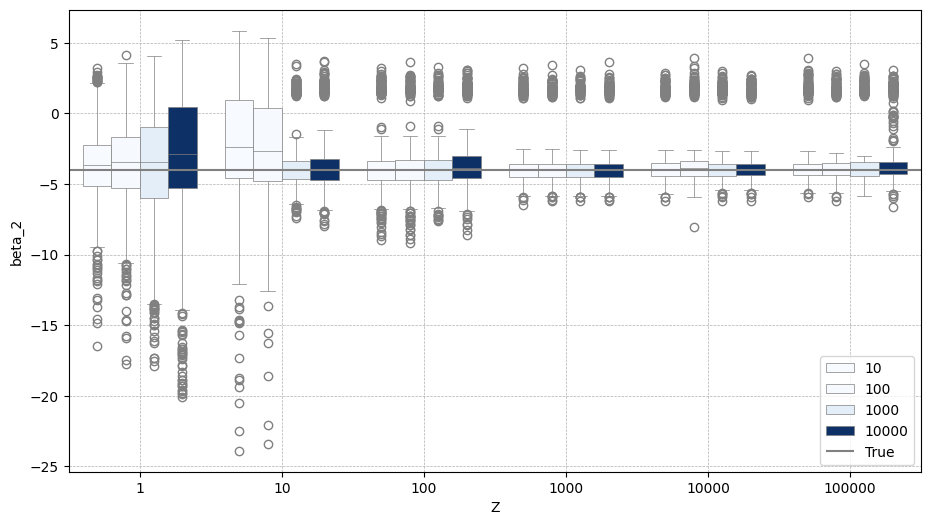

In [32]:
beta_df = pd.DataFrame(beta_estimated.reshape(-1, 3), columns=['alpha', 'beta_1', 'beta_2'])
beta_df['n0'] = np.tile(n0_candidates, 6000)
beta_df['Z'] = np.tile(np.repeat(Z_candidates, 4), 1000)

beta_df = beta_df[beta_df['alpha'].abs() < 30]
beta_df = beta_df[beta_df['beta_1'].abs() < 30]
beta_df = beta_df[beta_df['beta_2'].abs() < 30]

plt.figure(figsize=(11, 6))
sns.boxplot(x='Z', y='beta_2', data=beta_df, hue='n0', palette='Blues', saturation=0.9, linewidth=0.5, linecolor='grey')
plt.hlines(beta_true[2], -1, 6, color='grey', label='True')
plt.xlim(-0.5, 5.5)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)  

In [33]:
beta_df

,alpha,beta_1,beta_2,n0,Z
0,3.525377,4.443085,-3.444857,10,1
1,2.309933,1.712174,-2.090906,100,1
2,1.366759,-1.143148,-0.814968,1000,1
3,1.064363,-4.587978,0.433157,10000,1
4,-0.136105,-6.166385,0.833543,10,10
...,...,...,...,...,...
23993,-14.714047,7.206776,-4.137298,100,10000
23994,0.696657,0.665907,1.763454,1000,10000
23995,-7.414116,5.182205,-2.942134,10000,10000
23996,-9.716407,5.181431,-2.941756,10,100000
